<h3>In this file we will only do a SHAP analysis on our model from patient_survival

<h3>Please examine patient_survival.py first

In [35]:
# imports ..
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
import shap

from statistics import mean, stdev
warnings.filterwarnings("ignore")

In [36]:
data_folder = './data/'
train_file = f'{data_folder}training_v2.csv'
target = 'hospital_death'
patients_df = pd.read_csv(train_file)
patients_df_not_preprocessed = patients_df.copy()
patients_df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


<h4>Pre-processing

In [37]:
# remove nulls - for continues values use mean, for discrete use mode
for df in [patients_df, patients_df_not_preprocessed]:
    for column in list(df.columns):
        value_to_insert = None
        if df[column].dtype == float:
            #print(f'float value found! at: {column}')
            value_to_insert = df[column].mean()        
        else:
            value_to_insert = df[column].mode()[0]
        #print(f'column: {column}, replacing value: {value_to_insert}')
        df[column].fillna(value_to_insert, inplace=True)

    total_na = df.isna().sum().sum()
    total_null = df.isnull().sum().sum()
    assert total_na == 0 and total_null == 0

<h4>Data label encoding

In [38]:
# get all columns where the values are strings
string_columns = patients_df.select_dtypes(include=[object])
string_columns_names = list(string_columns.columns)


# replace these columns with their enumerated value
for column_name in string_columns_names:    
    enumerated_unique_values = list(enumerate(string_columns[column_name].unique()))
    value_to_index_mapper = dict([(y,x) for x,y in enumerated_unique_values])
    patients_df[column_name].replace(value_to_index_mapper, inplace=True)
    patients_df_not_preprocessed[column_name].replace(value_to_index_mapper, inplace=True)
# make sure no string columns are left
assert len(patients_df.select_dtypes(include=[object]).columns) == 0

<h4>Feature extraction

In [39]:
# columns in use
hospital_id_column_name = 'hospital_id'
patient_count_column_name = 'hospital_visit_count'
hospital_death_col_name = 'hospital_death'
hospital_death_count_col_name = 'hospital_death_count'
percent_of_deaths_col_name = 'percent_of_deaths_in_hospital'

In [40]:
# add feature counting how many visits were at a hospital

patients_df[patient_count_column_name] = patients_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('size')
hospital_to_visit_df = patients_df[[hospital_id_column_name, patient_count_column_name]].drop_duplicates().to_dict()[hospital_id_column_name]
mean_of_visits = round(mean(hospital_to_visit_df.values()))

# count how many deaths were recorded for each hospital

patients_df[hospital_death_count_col_name] = patients_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('sum')
hospital_to_hospital_death_count = patients_df[[hospital_id_column_name, hospital_death_count_col_name]].drop_duplicates().to_dict()[hospital_id_column_name]
mean_of_death_count = round(mean(hospital_to_hospital_death_count.values()))

# get the percent of deaths among visits in a hospital

patients_df[percent_of_deaths_col_name] = patients_df.apply(lambda row: round(row[hospital_death_count_col_name] / row[patient_count_column_name], 4), axis=1)
patients_df[[percent_of_deaths_col_name]]


,percent_of_deaths_in_hospital
0,118.0
1,81.0
2,118.0
3,118.0
4,33.0
...,...
91708,30.0
91709,121.0
91710,195.0
91711,66.0


<h4>Add clustering feature

In [41]:
# use clustering to extract another feature
# based on the float variables 
from sklearn.cluster import KMeans
import math

n_clusters = round(math.log(len(patients_df), 4))
float_columns = patients_df.select_dtypes(include=[float]).to_numpy()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=3).fit(float_columns)
patients_df['clustering_value'] = kmeans.predict(float_columns)

<h4>Remove id columns

In [42]:
main_id_col_name = 'encounter_id'
patients_df = patients_df[patients_df.columns.drop(list(patients_df.filter(regex='_id')))]


<h4>Feature selection

In [43]:
# simple feature selection based on minimum p-value similarity 
# with target value, based on ANOVA f-value

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

p_val_threshold = 0.01
select = SelectKBest(f_classif)
selected_df = select.fit_transform(patients_df, patients_df[target])
filter = select.get_support()
patients_df = patients_df[[name for i, name in enumerate(patients_df.columns) \
          if select.pvalues_[i] <= p_val_threshold]]
patients_df.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'pre_icu_los_days', 'weight',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=168)

In [44]:
# leave only certain amount of rows
n = 1000
patients_df = patients_df.head(n)
patients_df_not_preprocessed = patients_df_not_preprocessed.head(n)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

baseline_model = RandomForestClassifier(n_estimators=100)
our_model = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=10, random_state=42)
our_model_train, our_model_test = train_test_split(patients_df, test_size=0.2)
baseline_train, baseline_test = train_test_split(patients_df_not_preprocessed, test_size=0.2)

our_model.fit(our_model_train.drop(target, axis=1), our_model_train[target])
our_model_test_y = our_model_test[target]
our_model_predict_y = our_model.predict(our_model_test.drop(columns=[target]))
our_model_accuracy = accuracy_score(our_model_test_y, our_model_predict_y)

baseline_model.fit(baseline_train.drop(target, axis=1), baseline_train[target])
baseline_model_test_y = baseline_test[target]
baseline_model_predict_y = baseline_model.predict(baseline_test.drop(columns=[target]))
baseline_model_accuracy = accuracy_score(baseline_model_test_y, baseline_model_predict_y)



4. Evaluate model performance

In [46]:
baseline_train_y = baseline_train[target]
baseline_test_y = baseline_test[target]

baseline_train_X = baseline_train.drop(columns=[target])
baseline_test_X = baseline_test.drop(columns=[target])

baseline_model_train_accuracy = accuracy_score(baseline_train_y, baseline_model.predict(baseline_train_X))
baseline_model_test_accuracy = accuracy_score(baseline_test_y, baseline_model_predict_y)

our_model_train_accuracy = accuracy_score(our_model_train[target], our_model.predict(our_model_train.drop(columns=[target])))
our_model_test_accuracy = accuracy_score(our_model_test[target], our_model_predict_y)

print("Baseline Model Accuracy - Train Set:", baseline_model_train_accuracy)
print("Baseline Model Accuracy - Test Set:", baseline_model_test_accuracy)

print("Our Model Accuracy - Train Set:", our_model_train_accuracy)
print("Our Model Accuracy - Test Set:", our_model_test_accuracy)

Baseline Model Accuracy - Train Set: 1.0
Baseline Model Accuracy - Test Set: 0.955
Our Model Accuracy - Train Set: 0.98625
Our Model Accuracy - Test Set: 0.96


5. SHAP explanation for our_model


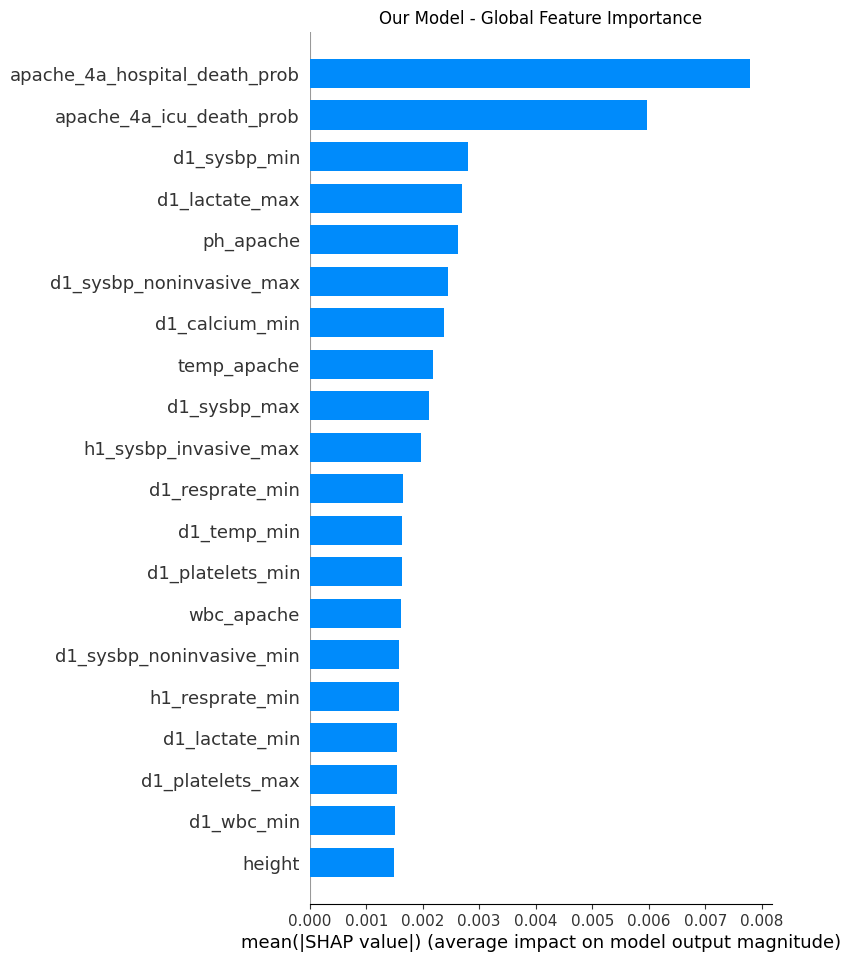

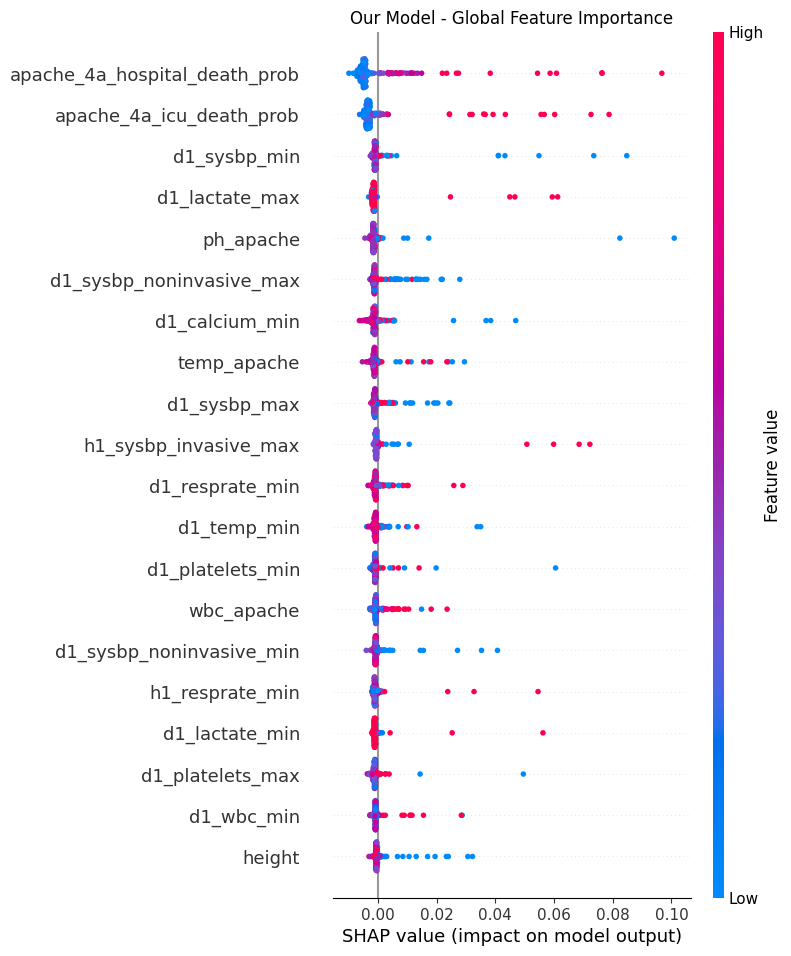

In [47]:
# 5 - Train the SHAP explainer using TreeSHAP
explainer = shap.TreeExplainer(our_model)

# Compute SHAP values for the entire test set using TreeSHAP
shap_values = explainer.shap_values(our_model_test.drop(columns=[target]))

# Plot summary plot for the entire test set
shap.summary_plot(shap_values[1], our_model_test.drop(columns=[target]), show=False, plot_type='bar')
plt.title("Our Model - Global Feature Importance")
plt.show()

shap.summary_plot(shap_values[1], our_model_test.drop(columns=[target]), show=False)
plt.title("Our Model - Global Feature Importance")
plt.show()


6. SHAP explanation for baseline_model using TreeShap and KernelShap

In [48]:
explainer_baseline_tree = shap.TreeExplainer(baseline_model)
shap_values_baseline_tree = explainer_baseline_tree.shap_values(baseline_train_X)

# SHAP explanation for baseline_model using KernelShap (with background)
background = shap.kmeans(baseline_train_X, 10)
explainer_baseline_kernel = shap.KernelExplainer(baseline_model.predict_proba, background)
shap_values_baseline_kernel = explainer_baseline_kernel.shap_values(baseline_train_X)

  0%|          | 0/800 [00:00<?, ?it/s]

7. Plotting SHAP explanations

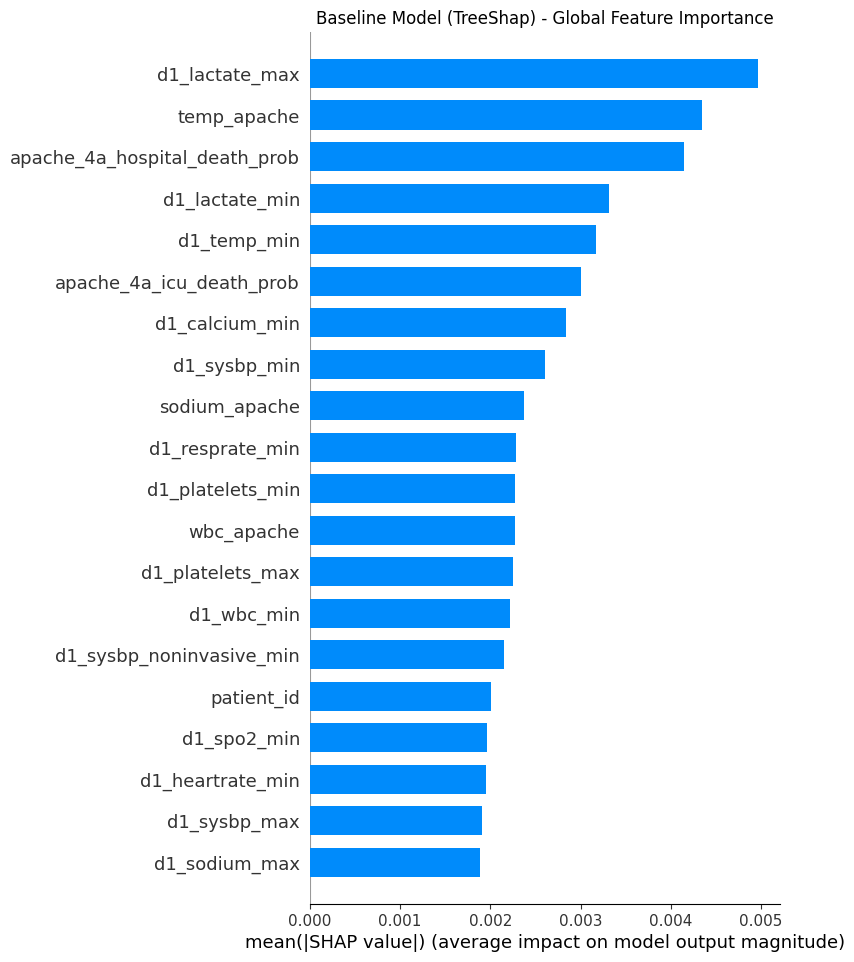

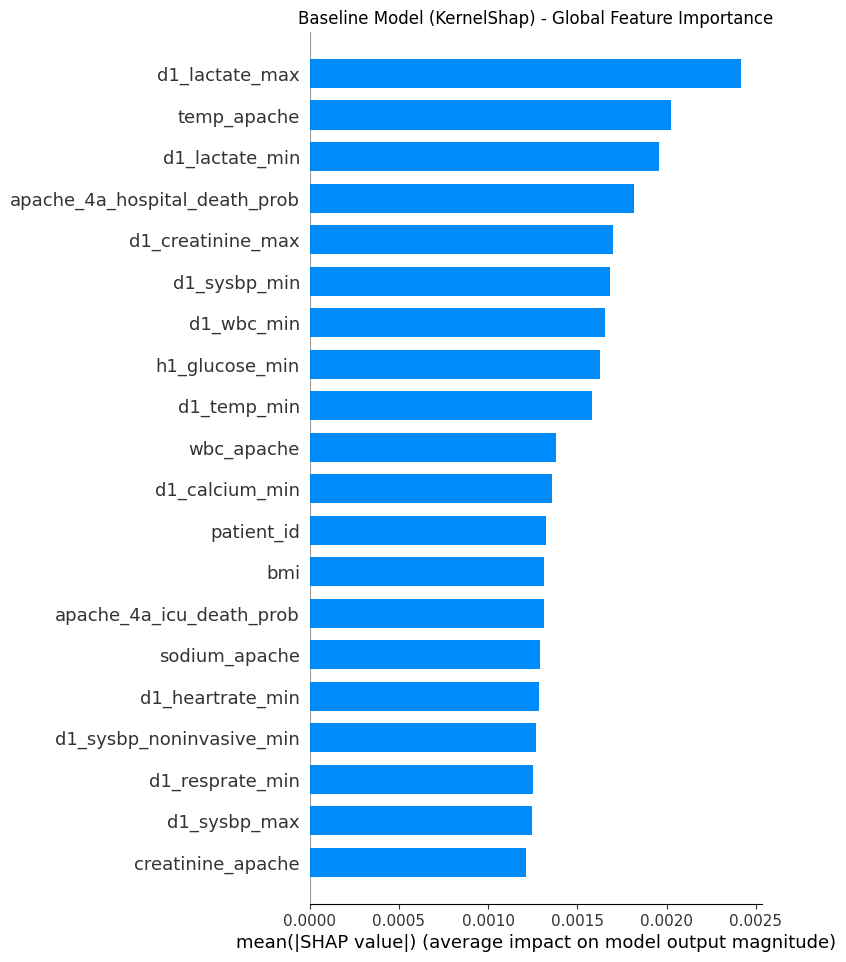

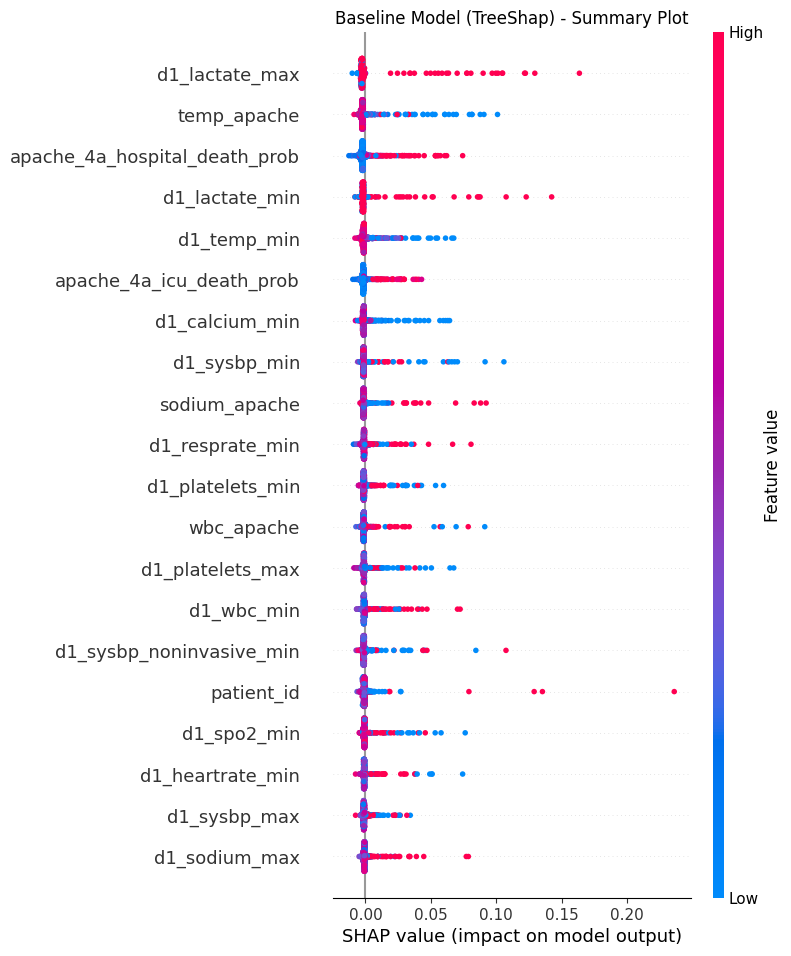

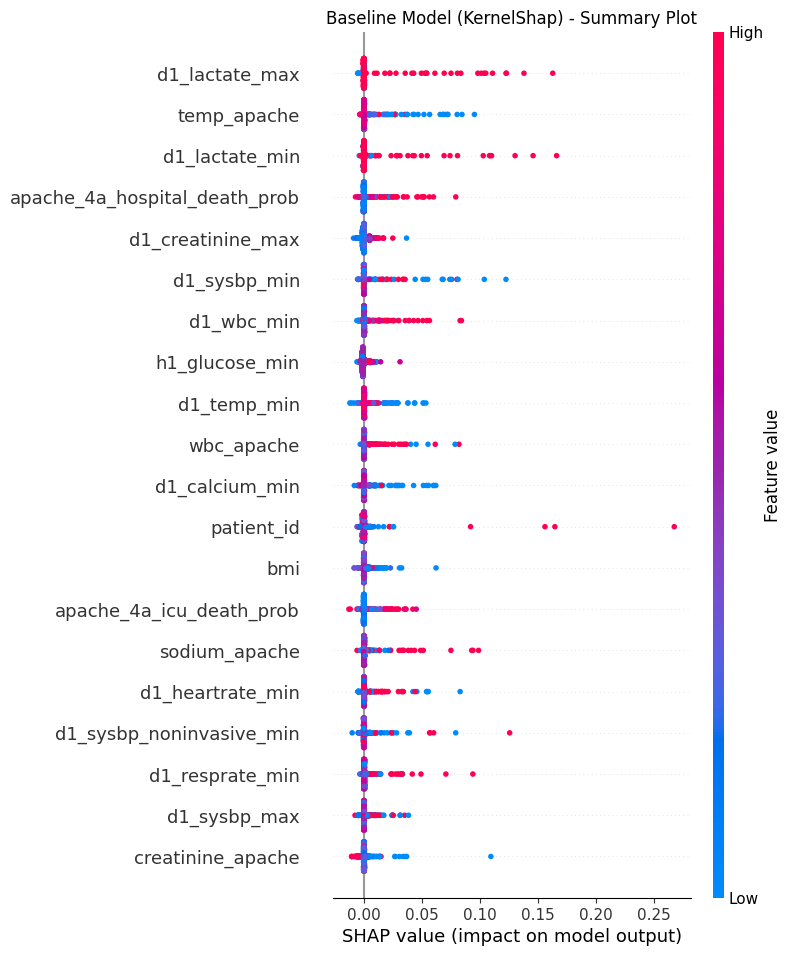

In [49]:

#Global Feature Importance
# shap.summary_plot(shap_values, our_model_train.drop(columns=[target]), show=False)
# plt.title("Our Model - Global Feature Importance")
# plt.show()

shap.summary_plot(shap_values_baseline_tree[1], baseline_train_X, show=False, plot_type='bar')
plt.title("Baseline Model (TreeShap) - Global Feature Importance")
plt.show()

shap.summary_plot(shap_values_baseline_kernel[1], baseline_train_X, show=False, plot_type='bar')
plt.title("Baseline Model (KernelShap) - Global Feature Importance")
plt.show()

# Summary Plot
# shap.summary_plot(shap_values, our_model_train.drop(columns=[target]), show=False)
# plt.title("Our Model - Summary Plot")
# plt.show()

shap.summary_plot(shap_values_baseline_tree[1], baseline_train_X, show=False)
plt.title("Baseline Model (TreeShap) - Summary Plot")
plt.show()

shap.summary_plot(shap_values_baseline_kernel[1], baseline_train_X, show=False)
plt.title("Baseline Model (KernelShap) - Summary Plot")
plt.show()

8. SHAP explanations for test set

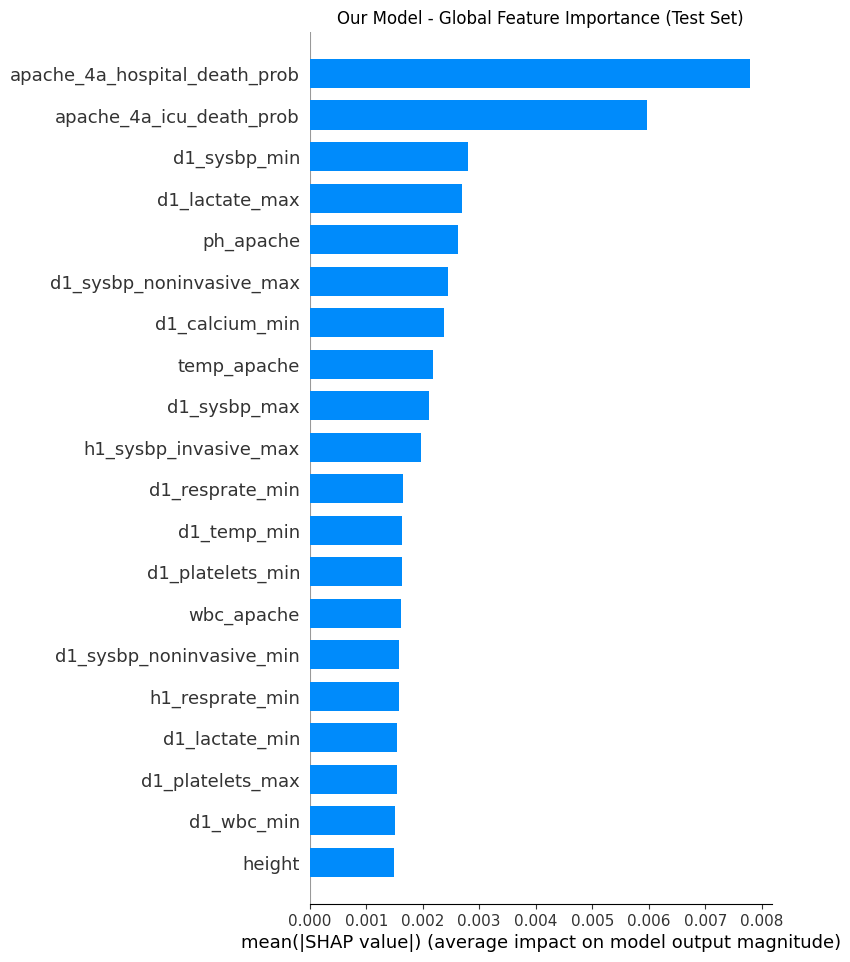

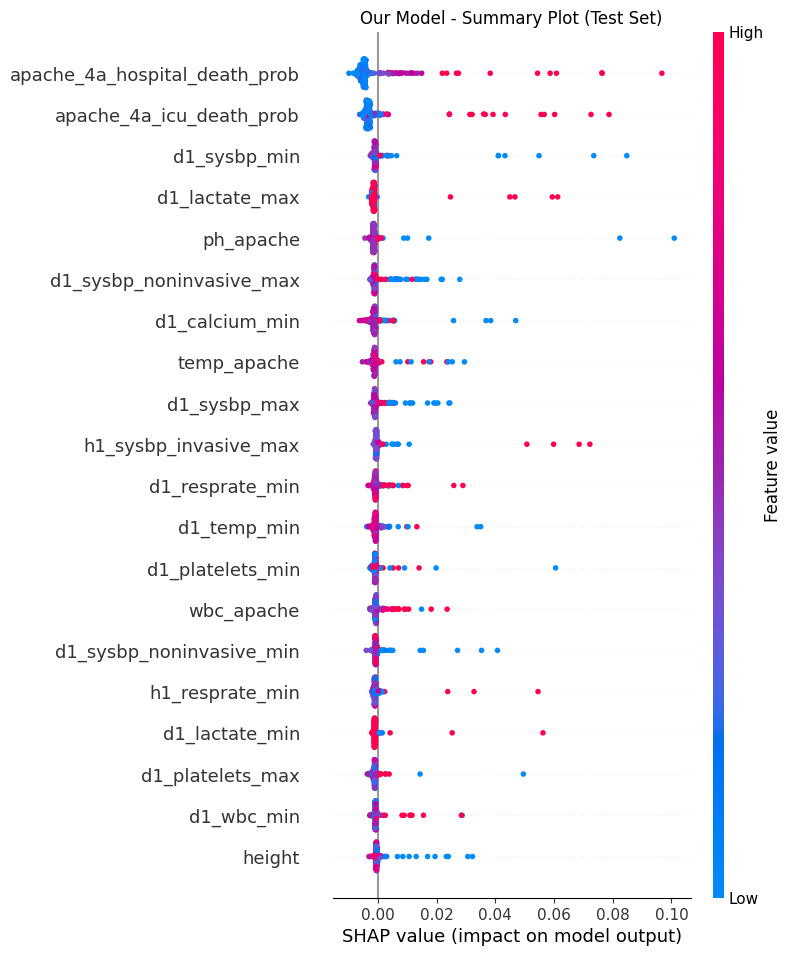

In [50]:
test_shap_values = explainer.shap_values(our_model_test.drop(columns=[target]))

shap.summary_plot(test_shap_values[1], our_model_test.drop(columns=[target]), show=False, plot_type='bar')
plt.title("Our Model - Global Feature Importance (Test Set)")
plt.show()

shap.summary_plot(test_shap_values[1], our_model_test.drop(columns=[target]), show=False)
plt.title("Our Model - Summary Plot (Test Set)")
plt.show()

9. SHAP explanations for misclassified test set

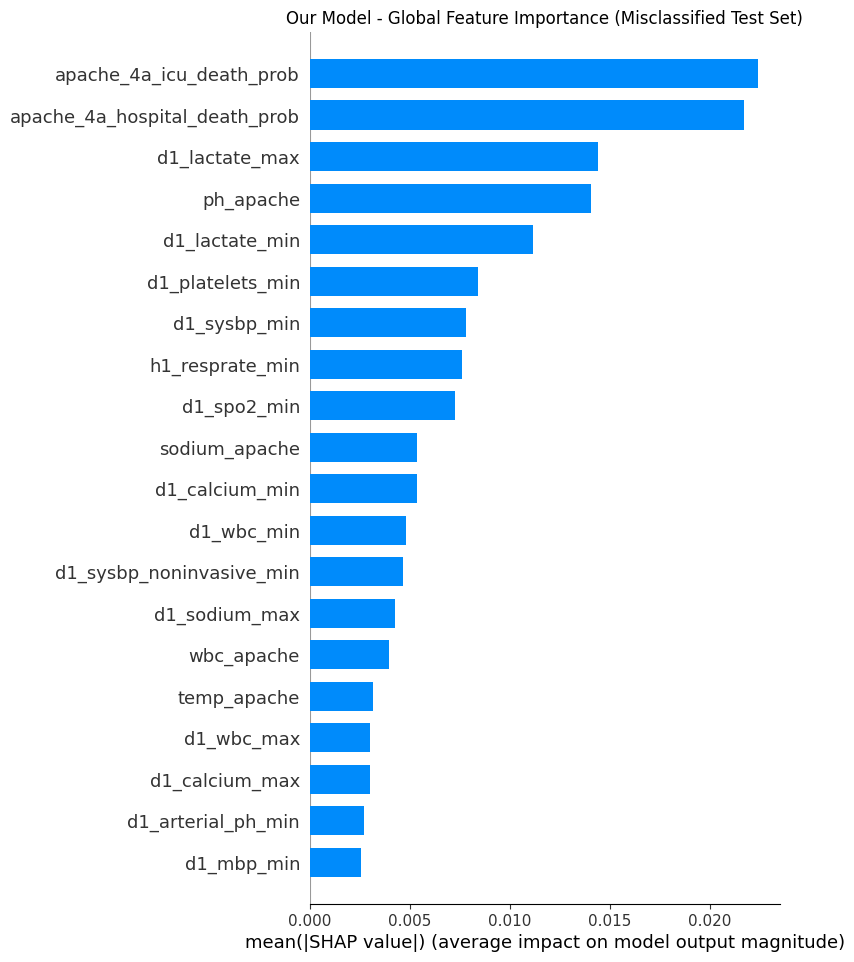

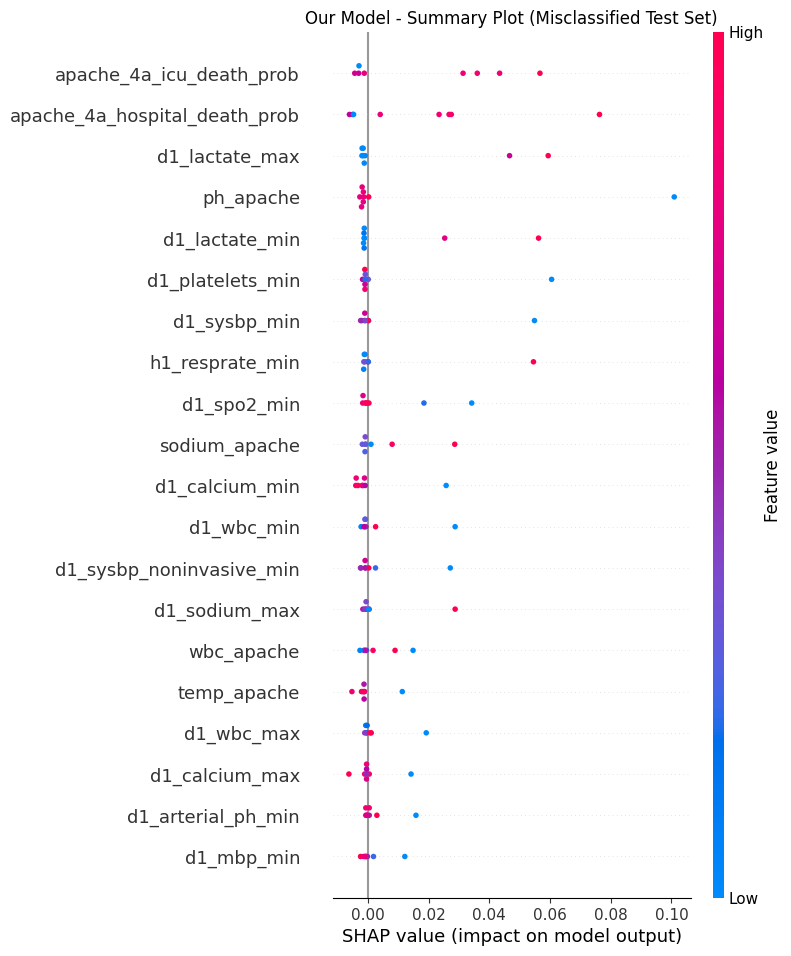

In [51]:
misclassified_indices = np.where(our_model_predict_y != our_model_test_y)[0]
misclassified_test = our_model_test.iloc[misclassified_indices]
misclassified_shap_values = explainer.shap_values(misclassified_test.drop(columns=[target]))

shap.summary_plot(misclassified_shap_values[1], misclassified_test.drop(columns=[target]), show=False, plot_type='bar')
plt.title("Our Model - Global Feature Importance (Misclassified Test Set)")
plt.show()

shap.summary_plot(misclassified_shap_values[1], misclassified_test.drop(columns=[target]), show=False)
plt.title("Our Model - Summary Plot (Misclassified Test Set)")
plt.show()

10. Individual explanations

In [52]:
true_classified_indices = np.where(our_model_predict_y == our_model_test_y)[0]

<h3> choose 2 from true classified and misclassified

In [53]:
true_classified_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  54,  55,
        57,  58,  59,  60,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

In [54]:
misclassified_indices

array([  8,  17,  30,  51,  56,  61, 151, 152], dtype=int64)

In [55]:
shap.initjs()

example_index = true_classified_indices[0]  # Specify the index of the example you want to interpret

# Get the corresponding SHAP values for the example
shap_true_values_example = test_shap_values[1][example_index]

# Get the corresponding example from the test set
example = our_model_test.iloc[example_index]

# Perform local interpretation using force_plot
shap.force_plot(explainer.expected_value[1], shap_true_values_example, example.drop(target))


In [56]:
example_index = true_classified_indices[1]  # Specify the index of the example you want to interpret

# Get the corresponding SHAP values for the example
shap_true_values_example = test_shap_values[1][example_index]

# Get the corresponding example from the test set
example = our_model_test.iloc[example_index]

# Perform local interpretation using force_plot
shap.force_plot(explainer.expected_value[1], shap_true_values_example, example.drop(target))

In [57]:
example_index = misclassified_indices[0]  # Specify the index of the example you want to interpret

# Get the corresponding SHAP values for the example
shap_false_values_example = test_shap_values[1][example_index]

# Get the corresponding example from the test set
example = our_model_test.iloc[example_index]

# Perform local interpretation using force_plot
shap.force_plot(explainer.expected_value[1], shap_false_values_example, example.drop(target))

In [58]:
example_index = misclassified_indices[1]  # Specify the index of the example you want to interpret

# Get the corresponding SHAP values for the example
shap_false_values_example = test_shap_values[1][example_index]

# Get the corresponding example from the test set
example = our_model_test.iloc[example_index]

# Perform local interpretation using force_plot
shap.force_plot(explainer.expected_value[1], shap_false_values_example, example.drop(target))